# AS - TME7-8
2018--2019

---

Binome : Juliette Ortholand, Stieban Fernandez

## Notes

Modèles de séquence (réccurents)
- Modèle sur les caractères (prédire classe)
- Modèle génératif

Données Page AS@DAC
-> names (classes) :
- english.txt
- french.txt
- italian.txt
- ...

Chaque caractère en 1-hot -> char-embedding

Etat précédent : s0 s1, s2, ... application d'une fonction f

+

Classifieur

On travaille avec des batchs

-> remplir caractère vide par 0 par ex

---

Pour les modèles génératifs : longueur du prénom + 1 caractère pour déterminer la fin de la chaine :

Appliquer un masque : 1 s'il y a un caractère (+ caractère de fin) sinon 0

-> Prédire à chaque fois l'état (/caractère) suivant.

Utilisation : 
- Est-ce que "Pierre" est un prénom anglais ? (Calcul de la vraisemblance)
- Générer des prénoms

---

## Librairies utiles

In [3]:
import torch
import torch.nn as nn
from unidecode import unidecode

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

from pathlib import Path
# Parcourir les fichiers du répértoire avec glob('*.txt')

import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm

## Préparation des données

In [4]:
#-------------------------------------------------------
# Extraction des noms et labels
#-------------------------------------------------------
gen = Path("data/names").glob("*.txt")

L = [] # [(nom, pays), ...]
D = {} # {label(int): pays, ...}
for label, file in enumerate(gen):
    D[label] = file.stem
    
    with open(str(file), "r", encoding="utf-8") as f:
        names = f.read().split("\n")[:-1]
    for name in names:
        # Nettoyage
        name = "".join([c for c in unidecode(name.lower()) if c.isalpha()])
        L.append((name, label))

#-------------------------------------------------------
# Encodage
#-------------------------------------------------------
N = 27 # nombre de caractères différents pour le one hot

code_char = lambda x: ord(x)-96

decode_char = lambda x: chr(x+96)

def encode_name(name, N, M=None):
    # N : taille d'un vecteur one hot
    # M : padding
    res = torch.zeros((M if M!=None and M>len(name) else len(name)))
    #res = torch.zeros((M if M!=None and M>len(name) else len(name)), N)
    for i, c in enumerate(name):
        res[i] = code_char(c)
        #res[i, code_char(c)] = 1
    #res[len(name):, 0] = 1
    return res

def decode_name(indxs):
    return "".join([decode_char(indx) for indx in indxs if indx!=0])
    #return "".join([decode_char(indx.argmax()) for indx in indxs if indx[0]!=1])

#-------------------------------------------------------
# Construction du DataSet 
#-------------------------------------------------------
class NameDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        name, label = self.data[index]
        return encode_name(name, N), int(label)
    
    def __len__(self):
        return len(self.data)
    
#-------------------------------------------------------
# DataLoader
#-------------------------------------------------------

def collate_fn(sequences):
    length = max([len(x[0]) for x in sequences])
    data = torch.zeros(len(sequences), length)
    #data = torch.zeros(len(sequences), length, N)
    target = torch.zeros(len(sequences))
    for i, (name, label) in enumerate(sequences):
        data[i, :len(name)] = name
        #data[i, len(name):, 0] = 1 # padding pour s'adapter aux dimensions du batch
        data[i, len(name):] = 0
        target[i] = label
    return data, target
        
    
def get_data_loader(dataset, batch_size):
    return DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, \
                         collate_fn=collate_fn)

#-------------------------------------------------------
# Split Train Val
#-------------------------------------------------------

X, y = np.array(L).T
Xtrain, Xval, ytrain, yval = train_test_split(X, y)

train_set = NameDataset(np.vstack((Xtrain, ytrain)).T)
val_set = NameDataset(np.vstack((Xval, yval)).T)

train_iter = get_data_loader(train_set, 150)
val_iter = get_data_loader(val_set, 150)

In [5]:
decode_name(encode_name("pierre", N, 19))

'pierre'

In [6]:
for x, y in train_iter:
    ex, lab = x, y
    print(x.shape, y.shape)
    break

torch.Size([150, 12]) torch.Size([150])


---

## Reccurent Neural Network

### Modèle

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.emb = nn.Embedding(27,input_size)
        
        self.linx = nn.Linear(input_size, hidden_size)
        self.linh = nn.Linear(hidden_size, hidden_size)
        self.activ = nn.ReLU()
        self.liny = nn.Linear(hidden_size, output_size)
        
    def forward(self, seq):
        # seq : (seq_length, batch_size)
        
        emb_seq = self.emb(seq)
        output = self.initHidden()
        
        for _input in emb_seq:
            output = self.activ(self.linx(_input) + self.linh(output))
        output = self.liny(output)
        
        return output

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

input_size, hidden_size, output_size = 50, 110, len(D)

In [126]:
# TEST
model = RNN(input_size, hidden_size, output_size)
out = model(ex.transpose(0,1).long())

for i, e in enumerate(out):
    print(decode_name(ex[i]), ":", D[e.argmax().item()])

irvinaaaaaaaa : Czech
vyalykhaaaaaa : Czech
peersaaaaaaaa : Czech
gladunaaaaaaa : Czech
charykovaaaaa : Czech
simonaaaaaaaa : Czech
yafarovaaaaaa : Czech
bickleyaaaaaa : Czech
doinikovaaaaa : Czech
plisaaaaaaaaa : Czech
zhekulinaaaaa : Czech
tomaaaaaaaaaa : Czech
murphyaaaaaaa : Czech
demallaaaaaaa : Czech
aloaaaaaaaaaa : Czech
minamiaaaaaaa : Czech
feigenbaumaaa : Czech
tsenaaaaaaaaa : Czech
bakhshievaaaa : Czech
hainaaaaaaaaa : Czech
tsarskyaaaaaa : Czech
strandaaaaaaa : Czech
lebinsonaaaaa : Czech
shakhmametiev : Polish
leichikaaaaaa : Czech
alybinaaaaaaa : Czech
valchikovskia : Vietnamese
jankevichaaaa : Czech
yasuiaaaaaaaa : Czech
storraaaaaaaa : Czech
ostcliffeaaaa : Czech
snowdenaaaaaa : Czech
abdildinaaaaa : Czech
stiloaaaaaaaa : Czech
nusuevaaaaaaa : Czech
loweaaaaaaaaa : Czech
sutherlandaaa : Czech
zherebtsovaaa : Czech
werneraaaaaaa : Czech
vyrodkovaaaaa : Czech
hudoinatovaaa : Czech
freestoneaaaa : Czech
bambachaaaaaa : Czech
backeraaaaaaa : Czech
bazjinaaaaaaa : Czech
gudk

### Classification

In [14]:
model = RNN(input_size, hidden_size, output_size)
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

def accuracy(ypred, y):
    ### Calcul du score
    return (ypred.argmax(dim=1) == y).float().mean()

def fit_eval_rnn(model, loss, optim, train_iter, val_iter, n_epochs):
    train_loss = []
    train_score = []
    val_loss = []
    val_score = []

    ### APPRENTISSAGE
    #--------------------------------------------------------
    for i in tqdm(range(n_epochs)):
        
        model.train()
        ####### TRAIN #######
        costs_train = []
        scores_train = []
        for x, l in train_iter:

            x = x.transpose(0,1).long()
            l = l.long()

            out = model(x)
            cost = loss(out, l)
            optim.zero_grad()
            cost.backward()
            optim.step()

            costs_train.append(cost)
            scores_train.append(accuracy(out, l))

        train_loss.append(torch.tensor(costs_train).mean())
        train_score.append(torch.tensor(scores_train).mean())

        model.eval()
        ####### VALID #######
        costs_val = []
        scores_val = []
        for x, l in val_iter:
            x = x.transpose(0,1).long()
            l = l.long()

            out = model(x)
            cost = loss(out, l)

            costs_val.append(cost)
            scores_val.append(accuracy(out, l))

        val_loss.append(torch.tensor(costs_val).mean())
        val_score.append(torch.tensor(scores_val).mean())
        
    return train_loss, val_loss, train_score, val_score


def show_loss_score(train_loss, val_loss, train_score, val_score):
    ### AFFICHAGE LOSS ET SCORE
    #--------------------------------------------------------
    plt.figure(figsize=(10,7))
    plt.plot(train_loss, c="red", label="train")
    plt.plot(val_loss, c="b", label="val")
    plt.legend(loc="best")
    plt.show()

    plt.figure(figsize=(10,7))
    plt.plot(train_score, c="red", label="train")
    plt.plot(val_score, c="b", label="val")
    plt.legend(loc="best")
    plt.show()

100%|██████████████████████████████████████████| 20/20 [04:40<00:00, 13.36s/it]


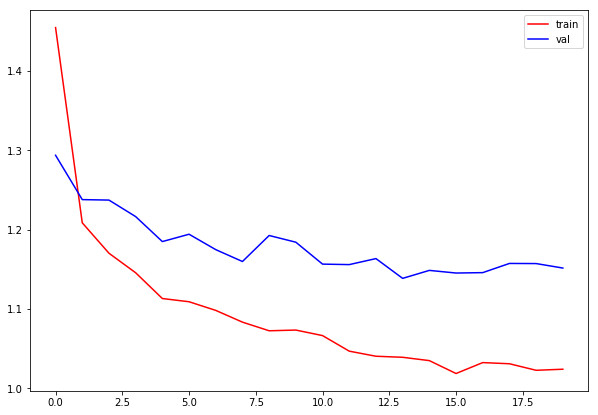

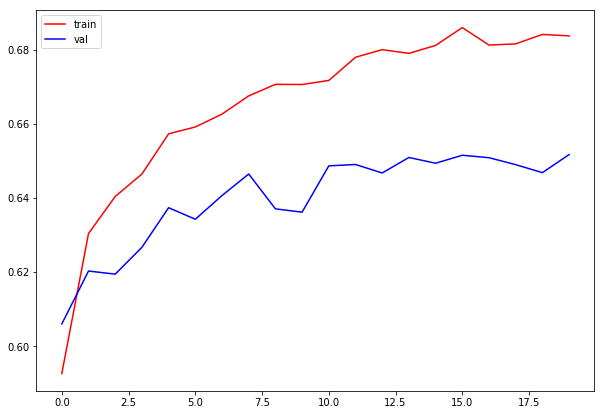

In [173]:
res = fit_eval_rnn(model, loss, optim, train_iter, val_iter, n_epochs)
show_loss_score(*res)

In [32]:
import collections

collections.Counter(list(ytrain)+list(yval))

Counter({'4': 3668,
         '14': 9408,
         '0': 2000,
         '6': 724,
         '3': 297,
         '8': 232,
         '2': 519,
         '5': 277,
         '10': 991,
         '16': 298,
         '12': 139,
         '7': 203,
         '1': 268,
         '11': 94,
         '9': 709,
         '15': 100,
         '17': 73,
         '13': 74})

Résultat biaisé car certaines classes contiennent plus d'exemples que d'autres

--> Preprocessing nécessaire : rebalancage des classes pour l'apprentissage

---

## Génération

Deux méthodes d'apprentissage possibles :
- Apprendre seulement des prénoms d'un pays
- Apprentissage générique (tous les pays) --> possiblement en injectant la catégorie (voir tuto Pytorch)

Ci-dessous nous utilisons la première méthode.

### Modèle

In [15]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()

        self.hidden_size = hidden_size
        
        self.emb = nn.Embedding(27,input_size)
        
        self.linx = nn.Linear(input_size, hidden_size)
        self.linh = nn.Linear(hidden_size, hidden_size)
        self.activ = nn.ReLU()
        self.liny = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        # x : (batch_size)
        
        emb_x = self.emb(x)
        hidden = self.activ(self.linx(emb_x) + self.linh(hidden))
        output = self.liny(hidden)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

input_size, hidden_size, output_size = 50, 110, 27
model = RNN2(input_size, hidden_size, output_size)

In [16]:
# TEST
output, hidden = model(torch.tensor([1, 2]), model.initHidden())
print(output.shape, hidden.shape)

torch.Size([2, 27]) torch.Size([2, 110])


### Apprentissage

Commencons par entrainer les prénoms appartenant à un pays spécifique

$ \rightarrow $ Obtenir un Dataset ne contenant que des noms d'un pays

In [17]:
def get_dataloaders_country(country, batch_size=32):
    L_country = [x for x in L if x[1] == country]

    X, y = np.array(L_country).T
    Xtrain, Xval, ytrain, yval = train_test_split(X, y)

    train_set = NameDataset(np.vstack((Xtrain, ytrain)).T)
    val_set = NameDataset(np.vstack((Xval, yval)).T)

    train_iter = get_data_loader(train_set, batch_size)
    val_iter = get_data_loader(val_set, batch_size)
    
    return train_iter, val_iter

In [18]:
def accuracy(ypred, y):
    ### Calcul du score
    return (ypred.argmax(dim=1) == y).float().mean()


def fit_eval_rnn_gen(model, loss, optim, train_iter, val_iter, n_epochs):
    train_loss = []
    train_score = []
    val_loss = []
    val_score = []

    ### APPRENTISSAGE
    #--------------------------------------------------------
    for i in tqdm(range(n_epochs)):
        
        model.train()
        ####### TRAIN #######
        costs_train = []
        scores_train = []
        for x, l in train_iter:

            x = x.transpose(0,1).long()
            
            hidden = model.initHidden()
            for i in range(len(x)-1):
                c, next_c = x[i], x[i+1]
                
                out, hidden = model(c, hidden)
                cost = loss(out, next_c)
                
                optim.zero_grad()
                cost.backward(retain_graph=True)
                optim.step()
                

                costs_train.append(cost)
                scores_train.append(accuracy(out, next_c))

        train_loss.append(torch.tensor(costs_train).mean())
        train_score.append(torch.tensor(scores_train).mean())

        model.eval()
        ####### VALID #######
        costs_val = []
        scores_val = []
        for x, l in val_iter:
            x = x.transpose(0,1).long()
            
            hidden = model.initHidden()
            for i in range(len(x)-1):
                c, next_c = x[i], x[i+1]
                
                out, hidden = model(c, hidden)
                cost = loss(out, next_c)

                costs_val.append(cost)
                scores_val.append(accuracy(out, next_c))

        val_loss.append(torch.tensor(costs_val).mean())
        val_score.append(torch.tensor(scores_val).mean())
        
    return train_loss, val_loss, train_score, val_score

Test avec différents pays

1. Noms chinois

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 30.14it/s]


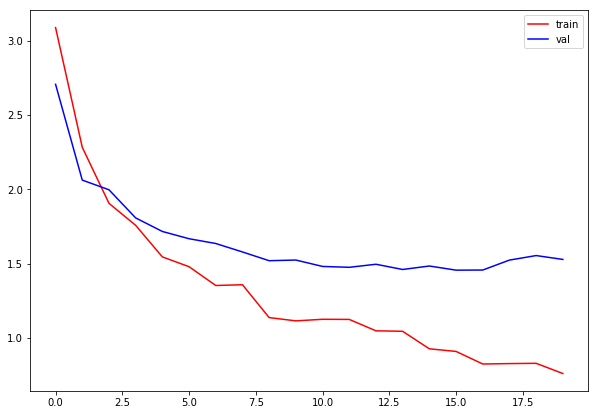

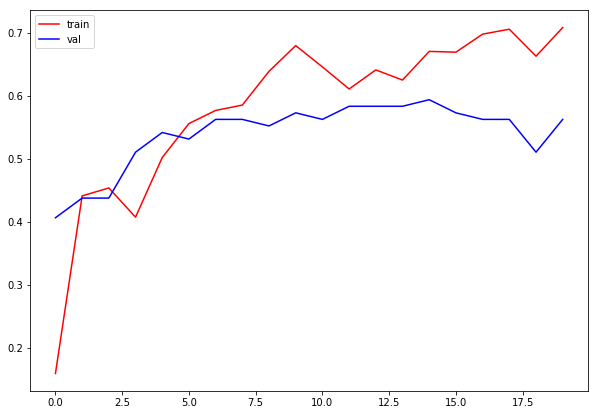

In [20]:
model = RNN2(input_size, hidden_size, output_size)
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

train_iter, val_iter = get_dataloaders_country(11)
res = fit_eval_rnn_gen(model, loss, optim, train_iter, val_iter, n_epochs)
show_loss_score(*res)

In [21]:
def generate_name(model, letter, maxlen=10):
    letter = encode_name(letter, 1).long()
    s = [letter]
    hidden = model.initHidden()
    
    for i in range(maxlen):
        out, hidden = model(letter, hidden)
        letter = out.argmax(1)
        s.append(letter)
    return decode_name(s)

In [22]:
alphabet = "abcdefghijklmnopqrstuvwxyz"

In [23]:
for l in alphabet:
    print(generate_name(model, l, 4))

ang
baik
cho
deon
eon
fng
gu
hong
im
jong
koo
lee
mang
noh
oo
park
qoo
ryo
soo
thon
ung
voo
wang
xong
yoo
za


2. Noms français

100%|██████████████████████████████████████████| 20/20 [00:04<00:00,  4.43it/s]


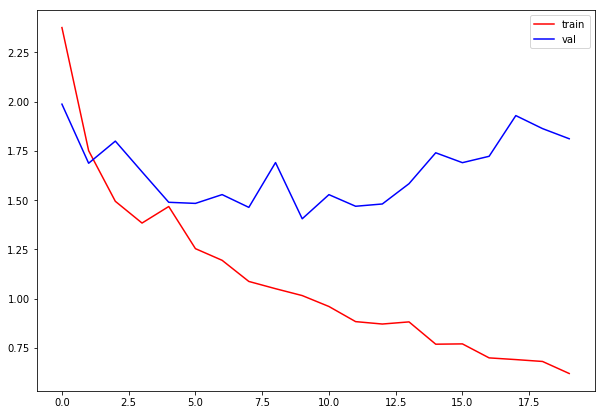

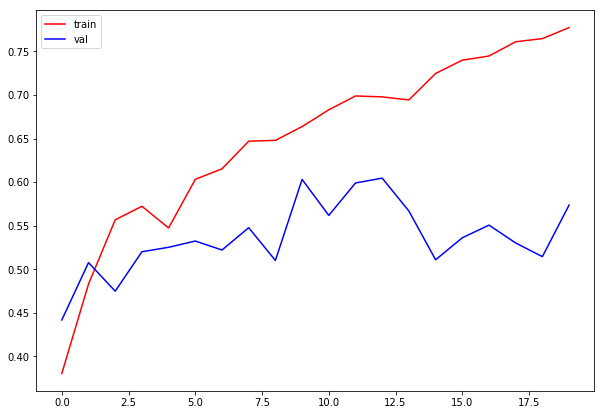

archand
bonnay
charbonneau
desauveterr
erreault
fabrin
gardinier
harbonneau
iron
jartrand
kourt
lestrange
martin
nardin
ourtin
paron
ques
roy
sauvage
traver
ullon
victors
wullon
xavigne
yoult
zullins


In [24]:
model = RNN2(input_size, hidden_size, output_size)
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

train_iter, val_iter = get_dataloaders_country(5)
res = fit_eval_rnn_gen(model, loss, optim, train_iter, val_iter, n_epochs)
show_loss_score(*res)

for l in alphabet:
    print(generate_name(model, l))

3. Noms italiens

100%|██████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


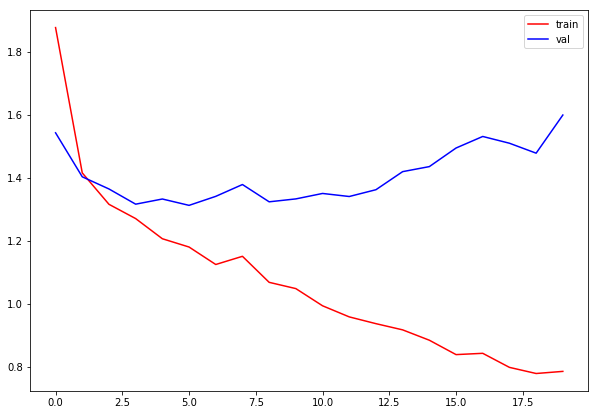

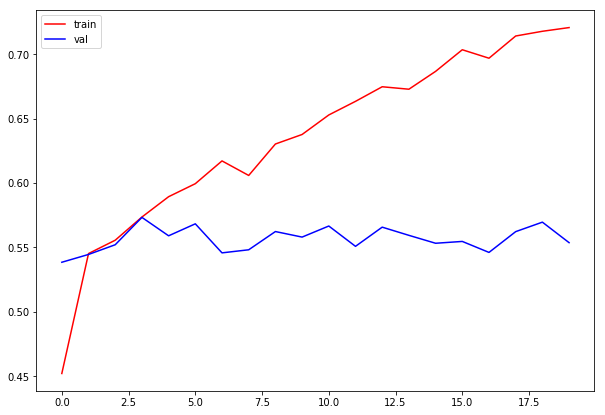

albricci
bassi
carano
dimaro
erraro
farri
giordano
hi
ino
jicolom
kespo
lagorio
morri
nicolosi
oresto
parri
quaro
rossi
salvasa
tessa
uggieri
vico
wucci
xutti
yino
zini


In [25]:
model = RNN2(input_size, hidden_size, output_size)
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

train_iter, val_iter = get_dataloaders_country(9)
res = fit_eval_rnn_gen(model, loss, optim, train_iter, val_iter, n_epochs)
show_loss_score(*res)

for l in alphabet:
    print(generate_name(model, l))

In [ ]:
...

### Autres méthodes pour la construction des batchs

In [ ]:
...